Source: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import math

In [2]:
filepath = "RELIANCE_2010-01-012021-08-30.csv"
data = pd.read_csv(filepath, usecols=[0,4], names=['date', 'close'], header=0)
data = data.sort_values('date')
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,close
0,2010-01-04,1075.50
1,2010-01-05,1070.70
2,2010-01-06,1088.00
3,2010-01-07,1106.05
4,2010-01-08,1103.15


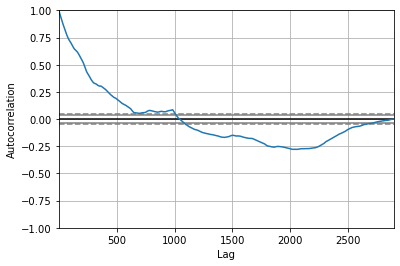

In [3]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(data['close'].values)
plt.show()

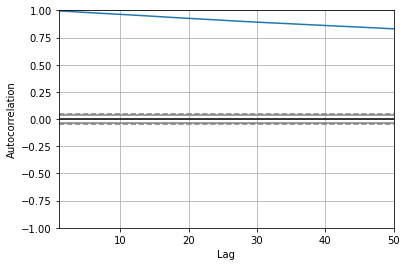

In [4]:
autocorrelation_plot(data['close'].values)
plt.xlim([1, 50])
plt.show()

#Choose p=20, d=1

In [5]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [6]:
stock_differenced = difference(data['close'].values)

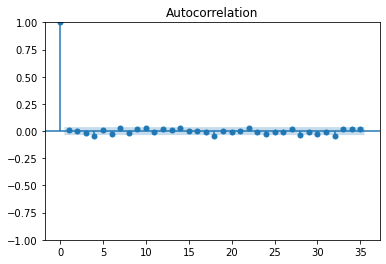

In [7]:
# https://otexts.com/fpp2/non-seasonal-arima.html

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(stock_differenced)
plt.show()

/home/ambekar/anaconda3/envs/rpy/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


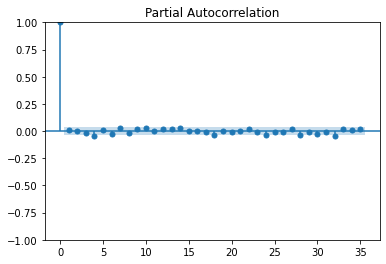

In [8]:
plot_pacf(stock_differenced)
plt.show()



In [9]:
def splitData(ts):

    test_set_size = int(np.round(0.2*len(ts)))
    train_set = ts[:-test_set_size]    
    test_set = ts[-test_set_size:]

    return train_set, test_set


In [10]:
train_set, test_set = splitData(data['close'].values)

In [21]:
len(train_set[-20:])

array([1360.  , 1363.25, 1391.85, 1389.7 , 1375.2 , 1353.05, 1353.9 ,
       1329.25, 1334.45, 1331.4 , 1346.8 , 1343.1 , 1340.15, 1343.75,
       1385.95, 1345.35, 1363.85, 1389.5 , 1372.4 , 1392.8 ])

In [11]:
model = ARIMA(train_set, order=(20,1,0))
model_fit = model.fit()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2316
Model:                ARIMA(20, 1, 0)   Log Likelihood              -10574.236
Date:                Mon, 31 Jan 2022   AIC                          21190.473
Time:                        17:37:09   BIC                          21311.163
Sample:                             0   HQIC                         21234.461
                               - 2316                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0072      0.034      0.208      0.835      -0.060       0.074
ar.L2         -0.0155      0.032     -0.491      0.623      -0.077       0.046
ar.L3         -0.0195      0.037     -0.529      0.5

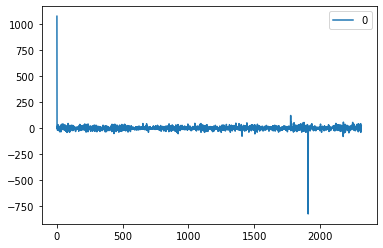

In [12]:
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

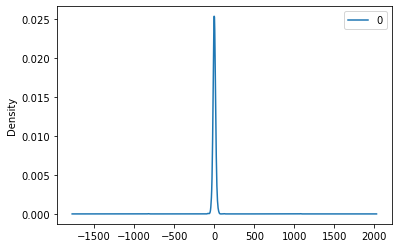

                 0
count  2316.000000
mean      0.609376
std      32.287808
min    -824.600668
25%      -9.158274
50%       0.034593
75%       9.830266
max    1075.500000


In [13]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [14]:
history = [x for x in train_set]
predictions = list()
# walk-forward validation
for t in range(len(test_set)):
	model = ARIMA(history, order=(0,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test_set[t]
	history.append(obs)
	# print('predicted=%f, expected=%f' % (yhat, obs))


Test RMSE: 34.802


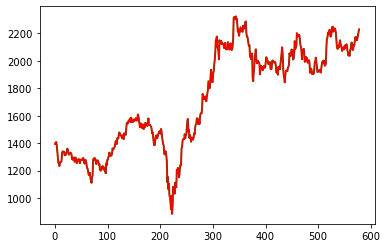

In [15]:
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test_set, predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
plt.plot(test_set, 'g')
plt.plot(predictions, color='red')
plt.show()

Test RMSE: 35.113


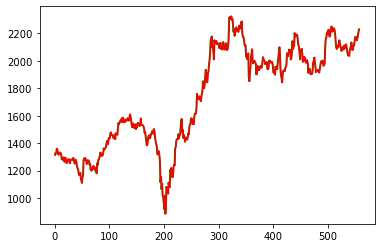

In [16]:
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test_set[20:], predictions[20:]))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
plt.plot(test_set[20:], 'g')
plt.plot(predictions[20:], color='red')
plt.show()

In [17]:
results = pd.DataFrame({'actual': test_set,
                       'forecasts': predictions})

In [18]:
results1 = pd.DataFrame({'actual': test_set[20:],
                       'forecasts': predictions[20:]})

In [19]:
results.to_csv('arima.csv', index=False)

In [20]:
results1.to_csv('arima1.csv', index=False)